## A very basic example from the NFlows Library

Ref. https://github.com/bayesiains/nflows/blob/master/examples/conditional_moons.ipynb

This is intended to get you started and have an idea of what the code will look like.

We will move to a hands on example afterwards where we will use data from a Nuclear Physics experiment.

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install nflows
!pip install pkbar
!pip install FrEIA
!pip install scipy

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

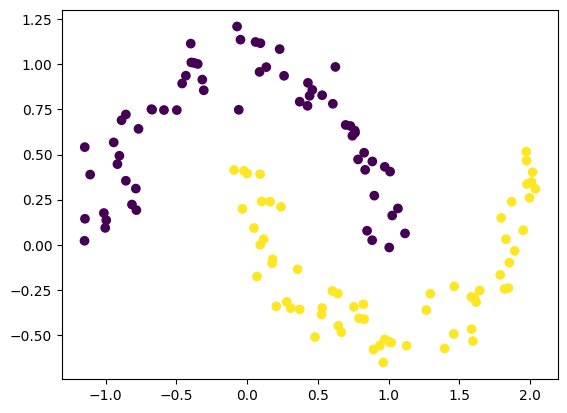

In [ ]:
# Basic imports

import matplotlib.pyplot as plt
import sklearn.datasets as datasets

import torch
from torch import nn
from torch import optim
import numpy as np
from nflows.flows.base import Flow
from nflows.distributions.normal import ConditionalDiagonalNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.nn.nets import ResidualNet
import pkbar

x, y = datasets.make_moons(128, noise=.1)
plt.scatter(x[:, 0], x[:, 1], c=y);

In [ ]:
# Check if we have a GPU
!nvidia-smi

Fri May 17 19:10:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_layers = 5
base_dist = ConditionalDiagonalNormal(shape=[2],
                                      context_encoder=nn.Linear(1, 4))

transforms = []
for _ in range(num_layers):
    # Permutations
    transforms.append(ReversePermutation(features=2))
    # Affine transformation
    # Notice this is affine, but also autoregressive
    # Autoregressive refers to the way the NN(x_2) functions - not important at this time
    # See slides for reference on affine functions.
    transforms.append(MaskedAffineAutoregressiveTransform(features=2,
                                                          hidden_features=4,
                                                          context_features=1))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist).to(device)
optimizer = optim.Adam(flow.parameters())

### Training and plotting

We are training the model through likelihood maximization. What we expect is that as the model progresses, the likelihood distribution should resemble a density over the data we inject.

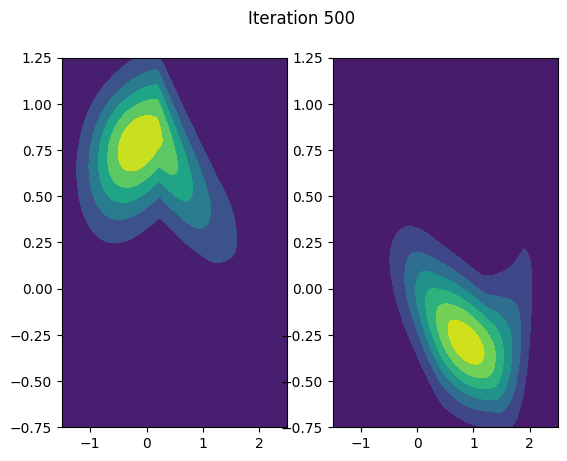

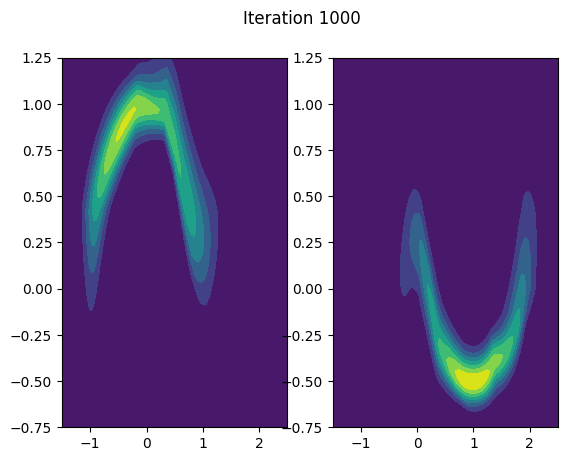

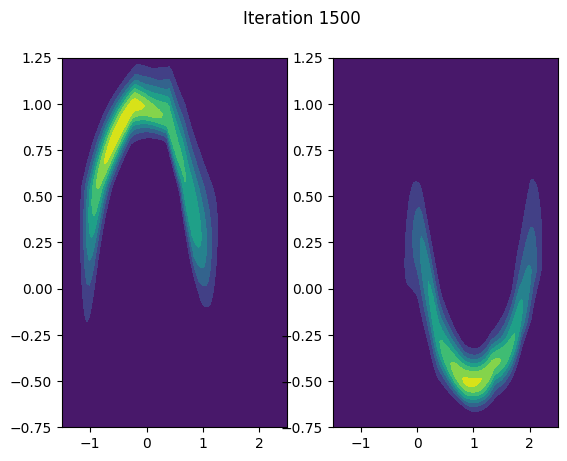

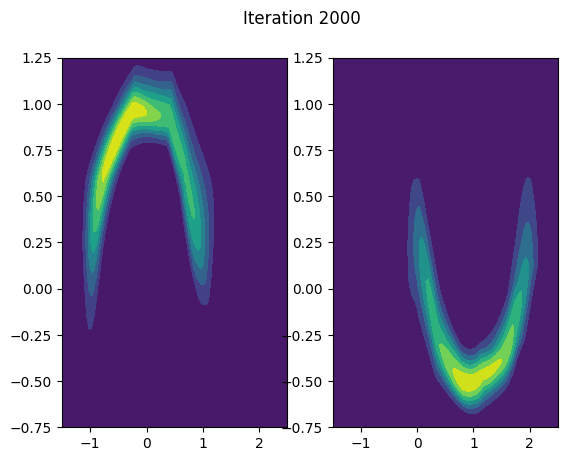

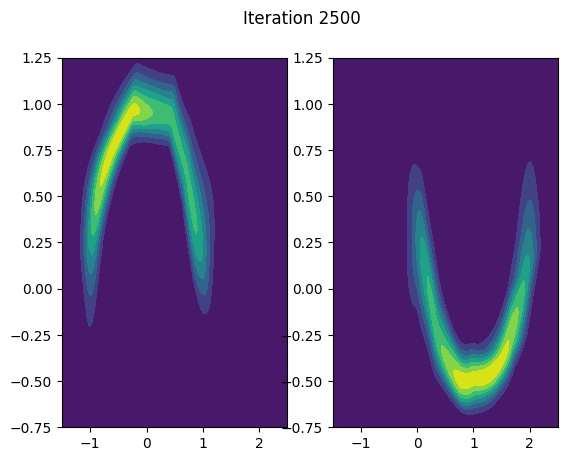

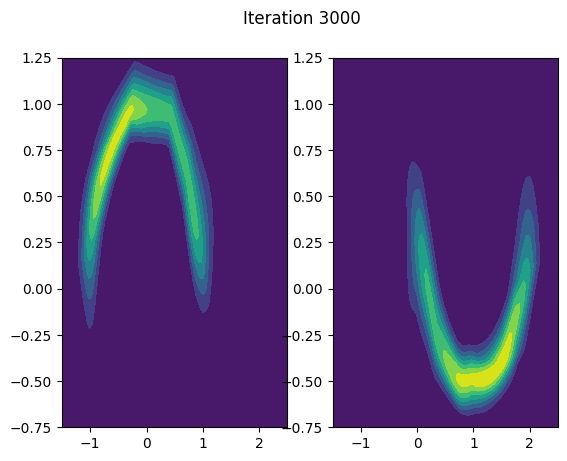

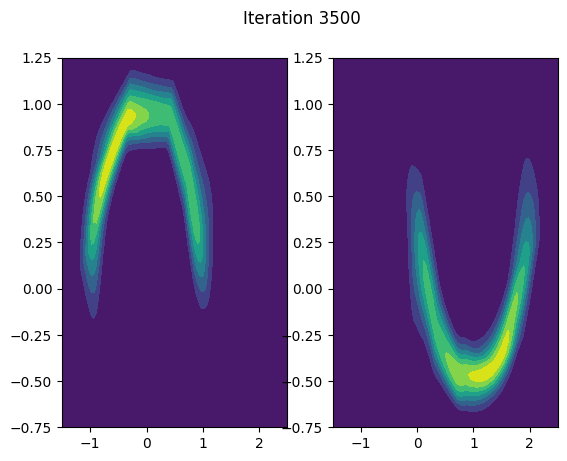

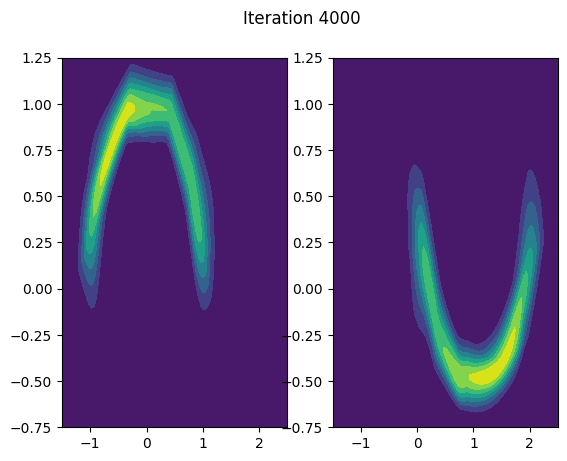

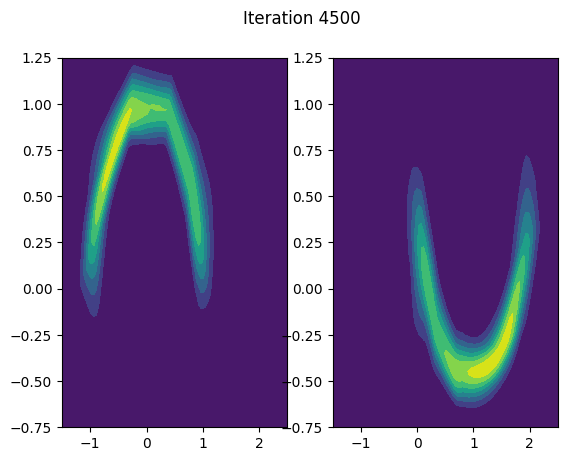

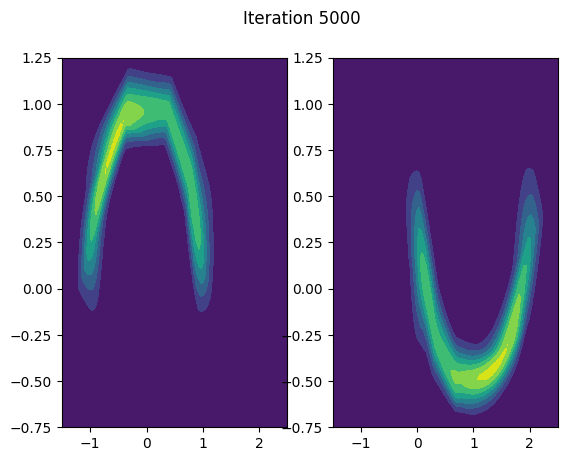

In [ ]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn import datasets

num_iter = 5000
for i in range(num_iter):
    x, y = datasets.make_moons(128, noise=.1)
    x = torch.tensor(x, dtype=torch.float32, device=device)
    y = torch.tensor(y, dtype=torch.float32, device=device).reshape(-1, 1)
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x, context=y).mean()
    loss.backward()
    optimizer.step()

    if (i + 1) % 500 == 0:
        fig, ax = plt.subplots(1, 2)
        xline = torch.linspace(-1.5, 2.5, steps=100)
        yline = torch.linspace(-.75, 1.25, steps=100)
        xgrid, ygrid = torch.meshgrid(xline, yline, indexing='ij')
        xgrid, ygrid = xgrid.to(device), ygrid.to(device)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            zgrid0 = flow.log_prob(xyinput, torch.zeros(10000, 1).to(device)).exp().reshape(100, 100).detach().cpu()
            zgrid1 = flow.log_prob(xyinput, torch.ones(10000, 1).to(device)).exp().reshape(100, 100).detach().cpu()

        ax[0].contourf(xgrid.cpu().numpy(), ygrid.cpu().numpy(), zgrid0.numpy())
        ax[1].contourf(xgrid.cpu().numpy(), ygrid.cpu().numpy(), zgrid1.numpy())
        plt.suptitle('Iteration {}'.format(i + 1))
        plt.show()

### What are we doing here?

1. We are training the model to learn the transformation $z = f(x)$
2. We are plotting the learned density over the distribution, $\textit{i.e.}$, the Probability Density Function over the two distinct classes.

Lets take it a step further. Now we want to sample our Normalizing Flow's base distribution, and perform the inverse transformation $x = f^{-1}(x)$ to generate artificial data.

torch.Size([500, 2])


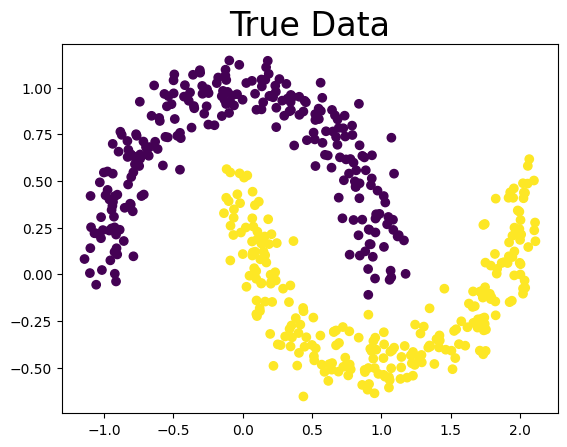

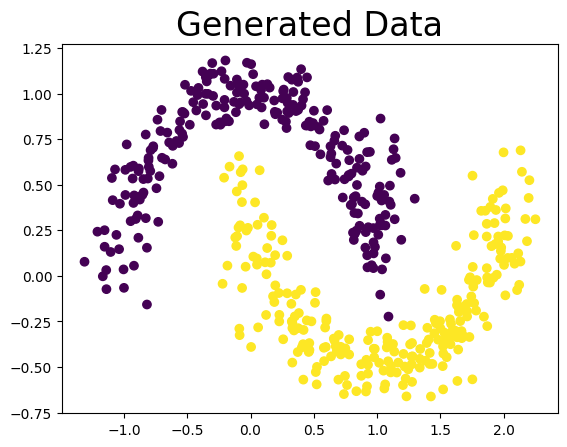

In [ ]:
# First lets sample some points from the true distributions to compare.

x, y = datasets.make_moons(500, noise=.1)

# Now lets create a representation of z from a Gaussian Distribution

z_y = torch.tensor(y).to(device).float().reshape(-1, 1)

# We would usually need to create a sample from a Gaussian distribution as follows:
# z = torch.tensor(np.random.normal(loc=0.0,scale=1.0,size=(500,2))).to(device).float()
# NFlows does this under the hood with their distributions! It is much cleaner and more reliable.

x_generated = flow.sample(num_samples=1,context=z_y).reshape(-1,2)
print(x_generated.shape)
x_generated = x_generated.detach().cpu().numpy()

plt.scatter(x[:, 0], x[:, 1], c=y)
plt.title('True Data',fontsize=24)
plt.show()


plt.scatter(x_generated[:,0],x_generated[:,1],c=y)
plt.title('Generated Data',fontsize=24)
plt.show()

### Can you use this to perform classification?

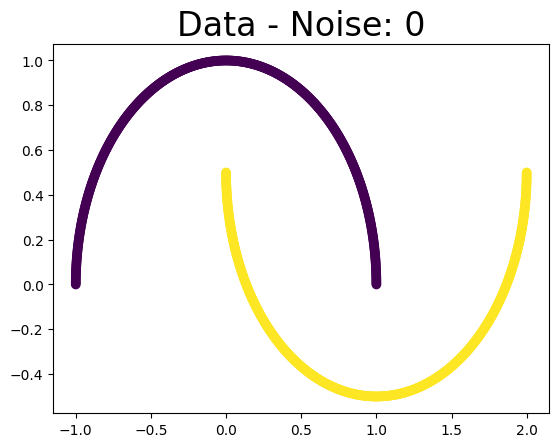

Accuracy:  100.0 %


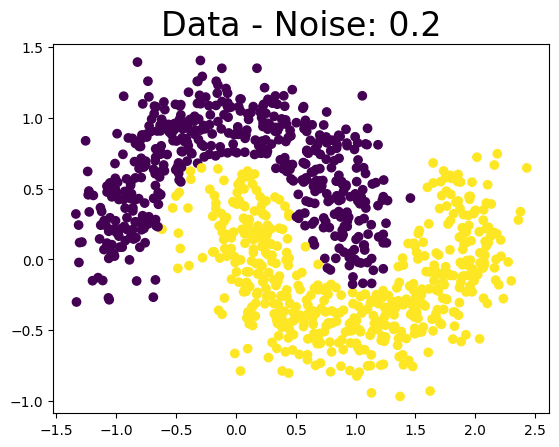

Accuracy:  96.7 %


In [ ]:
# First lets sample some points from the true distribution.
# We have trained with some width to the distributions
# Lets see classification results if we have no noise
sigma = 0
x, y = datasets.make_moons(1000, noise=sigma)


# Lets create two hypothesis and assume we do not know the ground truth labels
# Hypothesis of class 0
x_ = torch.tensor(x,device=device,dtype=torch.float32)
hyp_0 = torch.tensor(np.zeros_like(y),device=device,dtype=torch.float32).reshape(-1,1)
# Hypothesis of class 1
hyp_1 = torch.tensor(np.ones_like(y),device=device,dtype=torch.float32).reshape(-1,1)

LL_class_0 = flow.log_prob(x_,context=hyp_0).detach().cpu().numpy()
LL_class_1 = flow.log_prob(x_,context=hyp_1).detach().cpu().numpy()
# We can make predictions based off which likelihood is larger
y_pred = np.zeros_like(y)

y_pred[LL_class_1 > LL_class_0] = 1.0

plt.scatter(x[:, 0], x[:, 1], c=y_pred)
plt.title('Data - Noise: {0}'.format(sigma),fontsize=24)
plt.show()

print("Accuracy: ",(y_pred == y).sum() * 100 / len(y),"%")

# Lets see classification results if we have double the noise from training
sigma = 0.2
x, y = datasets.make_moons(1000, noise=sigma)


# Lets create two hypothesis and assume we do not know the ground truth labels
# Hypothesis of class 0
x_ = torch.tensor(x,device=device,dtype=torch.float32)
hyp_0 = torch.tensor(np.zeros_like(y),device=device,dtype=torch.float32).reshape(-1,1)
# Hypothesis of class 1
hyp_1 = torch.tensor(np.ones_like(y),device=device,dtype=torch.float32).reshape(-1,1)

LL_class_0 = flow.log_prob(x_,context=hyp_0).detach().cpu().numpy()
LL_class_1 = flow.log_prob(x_,context=hyp_1).detach().cpu().numpy()
# We can make predictions based off which likelihood is larger
y_pred = np.zeros_like(y)

y_pred[LL_class_1 > LL_class_0] = 1.0

plt.scatter(x[:, 0], x[:, 1], c=y_pred)
plt.title('Data - Noise: {0}'.format(sigma),fontsize=24)
plt.show()

print("Accuracy: ",(y_pred == y).sum() * 100 / len(y),"%")

Lets write a function to see how our performance changes as a function of noise.

Sigma =  0.0  Accuracy:  100.0 %
Sigma =  0.1  Accuracy:  99.8 %
Sigma =  0.2  Accuracy:  96.2 %
Sigma =  0.3  Accuracy:  87.0 %
Sigma =  0.4  Accuracy:  84.4 %
Sigma =  0.5  Accuracy:  75.8 %
Sigma =  0.6  Accuracy:  73.5 %
Sigma =  0.7  Accuracy:  69.4 %
Sigma =  0.8  Accuracy:  69.0 %
Sigma =  0.9  Accuracy:  66.7 %
Sigma =  1.0  Accuracy:  64.1 %


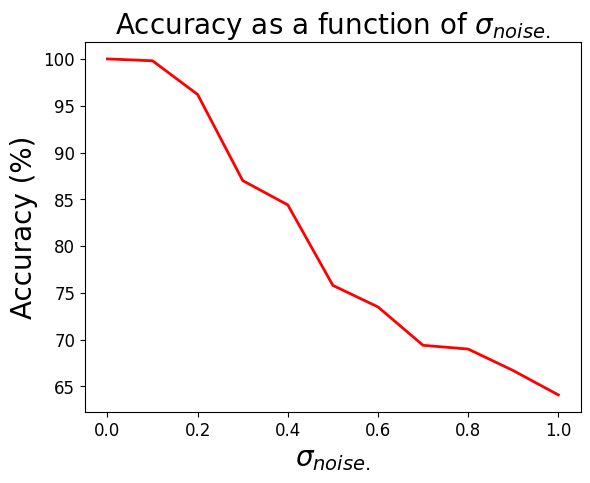

In [ ]:
def performance_func_noise(sigmas,flow):
  results = []
  for sigma in sigmas:
    x, y = datasets.make_moons(1000, noise=sigma)
    x_ = torch.tensor(x,device=device,dtype=torch.float32)
    hyp_0 = torch.tensor(np.zeros_like(y),device=device,dtype=torch.float32).reshape(-1,1)
    hyp_1 = torch.tensor(np.ones_like(y),device=device,dtype=torch.float32).reshape(-1,1)

    LL_class_0 = flow.log_prob(x_,context=hyp_0).detach().cpu().numpy()
    LL_class_1 = flow.log_prob(x_,context=hyp_1).detach().cpu().numpy()
    # We can make predictions based off which likelihood is larger
    y_pred = np.zeros_like(y)

    y_pred[LL_class_1 > LL_class_0] = 1.0
    print("Sigma = ",sigma," Accuracy: ",(y_pred == y).sum() * 100 / len(y),"%")
    results.append((y_pred == y).sum() * 100 / len(y))

  return results

sigmas = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
results = performance_func_noise(sigmas,flow)

plt.plot(sigmas,results,color='red',lw='2',linestyle='-')
plt.xlabel(r"$\sigma_{noise.}$",fontsize=20)
plt.ylabel("Accuracy (%)",fontsize=20)
plt.title(r"Accuracy as a function of $\sigma_{noise.}$",fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()